# Clustering Crypto

In [73]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Fetching Cryptocurrency Data

In [74]:
url = "https://min-api.cryptocompare.com/data/all/coinlist"
requests.get(url)
response_data = requests.get(url)

In [75]:
import json

# Formatting as json
data = response_data.json()

### Data Preprocessing

In [76]:
# Traspose the data
crypto_df = pd.DataFrame.from_dict(data["Data"],orient='index')
# Keep only cryptocurrencies that are on trading
crypto_df = crypto_df[crypto_df.IsTrading == True]
# Keep only cryptocurrencies with a working algorithm
# Dropping rows where there are 'N/A' text values
crypto_df = crypto_df[crypto_df.Algorithm != "N/A"]
crypto_df = crypto_df[crypto_df.TotalCoinSupply != "N/A"]
# Remove the "IsTrading" column
crypto_df.drop(['IsTrading'], axis=1,inplace = True)
# Removing rows with at least 1 null value
crypto_df = crypto_df.dropna(how='any',axis=0)
# Removing rows with cryptocurrencies without coins mined
crypto_df = crypto_df[crypto_df.TotalCoinsMined != 0]

In [77]:
# Fetching the cryptocurrencies names prior to drop them from crypto_df
df_aux = crypto_df['CoinName']
df_aux

42           42 Coin
1337       EliteCoin
BTCD     BitcoinDark
XPY          PayCoin
PRC      ProsperCoin
            ...     
NLG           Gulden
GAME     Gamecredits
SMART      SmartCash
EMC         Emercoin
MEC         MegaCoin
Name: CoinName, Length: 556, dtype: object

In [78]:
crypto_df.head()

,Id,Url,ImageUrl,ContentCreatedOn,Name,Symbol,CoinName,FullName,Algorithm,ProofType,...,PreMinedValue,TotalCoinsFreeFloat,SortOrder,Sponsored,Taxonomy,TotalCoinsMined,BlockNumber,NetHashesPerSecond,BlockReward,BlockTime
42,4321,/coins/42/overview,/media/35650717/42.jpg,1427211129,42,42,42 Coin,42 Coin (42),Scrypt,PoW/PoS,...,N/A,N/A,34,False,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...",4.199995e+01,152462.0,0.0,0.0,0.0
1337,20824,/coins/1337/overview,/media/35520987/elite.png,1465838687,1337,1337,EliteCoin,EliteCoin (1337),X13,PoW/PoS,...,N/A,N/A,577,False,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...",2.933949e+10,2318088.0,0.0,0.0,60.0
BTCD,4400,/coins/btcd/overview,/media/19630/btcd_1.png,1427711372,BTCD,BTCD,BitcoinDark,BitcoinDark (BTCD),SHA-256,PoW/PoS,...,N/A,N/A,13,False,"{'Access': 'Permissionless', 'FCA': 'Exchange'...",1.288862e+06,0.0,0.0,0.0,0.0
XPY,5030,/coins/xpy/overview,/media/20076/xpy_1.png,1428671950,XPY,XPY,PayCoin,PayCoin (XPY),SHA-256,PoS,...,N/A,N/A,17,False,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...",1.199533e+07,0.0,0.0,0.0,0.0
PRC,3638,/coins/prc/overview,/media/20393/prc.png,1424886122,PRC,PRC,ProsperCoin,ProsperCoin (PRC),Scrypt,PoW,...,N/A,N/A,18,False,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...",6.070325e+06,602982.0,1136826.0,5.0,120.0


In [79]:
# Remove unnecessary columns
# Removig the cryptocurrency name since it's not going to be used on the clustering algorithm
crypto_df.drop(['CoinName','PreMinedValue','TotalCoinsFreeFloat','BuiltOn','SmartContractAddress','Taxonomy','FullName','Name','Symbol','ImageUrl','Url','Id','ContentCreatedOn'], axis=1,inplace = True)

In [80]:
crypto_df.head()

,Algorithm,ProofType,FullyPremined,TotalCoinSupply,SortOrder,Sponsored,TotalCoinsMined,BlockNumber,NetHashesPerSecond,BlockReward,BlockTime
42,Scrypt,PoW/PoS,0,42,34,False,4.199995e+01,152462.0,0.0,0.0,0.0
1337,X13,PoW/PoS,0,314159265359,577,False,2.933949e+10,2318088.0,0.0,0.0,60.0
BTCD,SHA-256,PoW/PoS,0,22000000,13,False,1.288862e+06,0.0,0.0,0.0,0.0
XPY,SHA-256,PoS,0,12500000,17,False,1.199533e+07,0.0,0.0,0.0,0.0
PRC,Scrypt,PoW,0,21000000,18,False,6.070325e+06,602982.0,1136826.0,5.0,120.0


In [81]:
# to change objects to floats .astype() 
crypto_df['TotalCoinSupply'] = crypto_df.TotalCoinSupply.astype(float)
crypto_df['SortOrder'] = crypto_df.SortOrder.astype(float)
print(crypto_df.dtypes)

Algorithm              object
ProofType              object
FullyPremined          object
TotalCoinSupply       float64
SortOrder             float64
Sponsored                bool
TotalCoinsMined       float64
BlockNumber           float64
NetHashesPerSecond    float64
BlockReward           float64
BlockTime             float64
dtype: object


In [82]:
# Creating dummies variables for text features
df_encoded = pd.get_dummies(crypto_df, columns=["Algorithm","ProofType","FullyPremined","Sponsored"]) 

In [83]:
# Standardizing data
scaler = StandardScaler()
scaler.fit(df_encoded)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [84]:
scaled = StandardScaler().fit_transform(df_encoded)
scaled

array([[-0.15491219, -1.14579337, -0.12059772, ...,  0.2123977 ,
        -0.2123977 ,  0.        ],
       [ 4.58284385, -0.6767767 ,  0.53278856, ...,  0.2123977 ,
        -0.2123977 ,  0.        ],
       [-0.15458041, -1.16393214, -0.12056902, ...,  0.2123977 ,
        -0.2123977 ,  0.        ],
       ...,
       [-0.07950846,  0.04963771, -0.07069076, ...,  0.2123977 ,
        -0.2123977 ,  0.        ],
       [-0.13983144, -0.75710552, -0.11963878, ...,  0.2123977 ,
        -0.2123977 ,  0.        ],
       [-0.1542788 , -1.04127953, -0.11974574, ...,  0.2123977 ,
        -0.2123977 ,  0.        ]])

### Reducing Dimensions Using PCA

In [85]:
# Using PCA to reduce dimension to 3 principal components
pca = PCA(n_components=3)
data_pca = pca.fit_transform(scaled)
data_pca

array([[-0.59754913, -0.23289183, -0.9820036 ],
       [ 2.17770104, -0.3908791 , -0.62948162],
       [-0.50748332, -0.37633742, -0.65145546],
       ...,
       [-0.07249721, -0.61612798,  0.28753551],
       [-0.44289572, -0.40496198, -0.51710298],
       [-0.36272413, -0.40711245, -1.05848909]])

In [86]:
# Creating a DataFrame with the principal components data
df_pca = pd.DataFrame(
    data=data_pca, columns=["p1", "p2","p3"]
)
df_pca

,p1,p2,p3
0,-0.597549,-0.232892,-0.982004
1,2.177701,-0.390879,-0.629482
2,-0.507483,-0.376337,-0.651455
3,-0.338362,0.181992,0.153014
4,-0.391618,-0.400189,-1.092175
...,...,...,...
551,-0.361981,-0.419398,-1.008709
552,-0.353978,-0.431440,-0.940249
553,-0.072497,-0.616128,0.287536
554,-0.442896,-0.404962,-0.517103


### Clustering Crytocurrencies Using K-Means

#### Finding the Best Value for `k` Using the Elbow Curve

In [87]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range ok k values
# Create the Elbow Curve using hvPlot

for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(df_pca)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

:Curve   [k]   (inertia)

Running K-Means with `k=<you best value for k here>`

In [66]:
def get_clusters(k, data):
    # Initialize the K-Means model
    model = KMeans(n_clusters=k, random_state=0)

    # Fit the model
    model.fit(data)

    # Predict clusters
    predictions = model.predict(data)

    
    data["class"] = model.labels_

    return data

In [90]:
 # Creating a new DataFrame including predicted clusters and cryptocurrencies features
five_clusters = get_clusters(5, df_pca)
five_clusters.head(20)

,p1,p2,p3,class
0,-0.597549,-0.232892,-0.982004,2
1,2.177701,-0.390879,-0.629482,2
2,-0.507483,-0.376337,-0.651455,2
3,-0.338362,0.181992,0.153014,2
4,-0.391618,-0.400189,-1.092175,2
5,-0.448834,-0.283830,-0.503448,2
6,-0.236639,0.065032,0.551220,0
7,-0.302109,-0.393446,-1.125366,2
8,-0.576395,-0.233508,-0.982765,2
9,-0.255204,-0.492352,-0.822031,2


In [91]:
df_info = crypto_df[['Algorithm', 'ProofType', 'TotalCoinsMined','TotalCoinSupply']]
df_info.reset_index(inplace=True)
df_aux.reset_index(inplace=True, drop=True)
df_class = five_clusters[['class']]
result = pd.concat([df_info,df_pca,df_aux], axis=1, join='inner')

In [92]:
result

,index,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,p1,p2,p3,class,CoinName
0,42,Scrypt,PoW/PoS,4.199995e+01,4.200000e+01,-0.597549,-0.232892,-0.982004,2,42 Coin
1,1337,X13,PoW/PoS,2.933949e+10,3.141593e+11,2.177701,-0.390879,-0.629482,2,EliteCoin
2,BTCD,SHA-256,PoW/PoS,1.288862e+06,2.200000e+07,-0.507483,-0.376337,-0.651455,2,BitcoinDark
3,XPY,SHA-256,PoS,1.199533e+07,1.250000e+07,-0.338362,0.181992,0.153014,2,PayCoin
4,PRC,Scrypt,PoW,6.070325e+06,2.100000e+07,-0.391618,-0.400189,-1.092175,2,ProsperCoin
...,...,...,...,...,...,...,...,...,...,...
551,NLG,Scrypt,PoW,4.150324e+08,1.680000e+09,-0.361981,-0.419398,-1.008709,2,Gulden
552,GAME,Scrypt,PoW,6.983610e+07,8.400000e+07,-0.353978,-0.431440,-0.940249,2,Gamecredits
553,SMART,Keccak,PoW,2.241009e+09,5.000000e+09,-0.072497,-0.616128,0.287536,2,SmartCash
554,EMC,SHA-256,PoW/PoS,4.305979e+07,1.000000e+09,-0.442896,-0.404962,-0.517103,2,Emercoin


### Visualizing Results

#### 3D-Scatter with Clusters

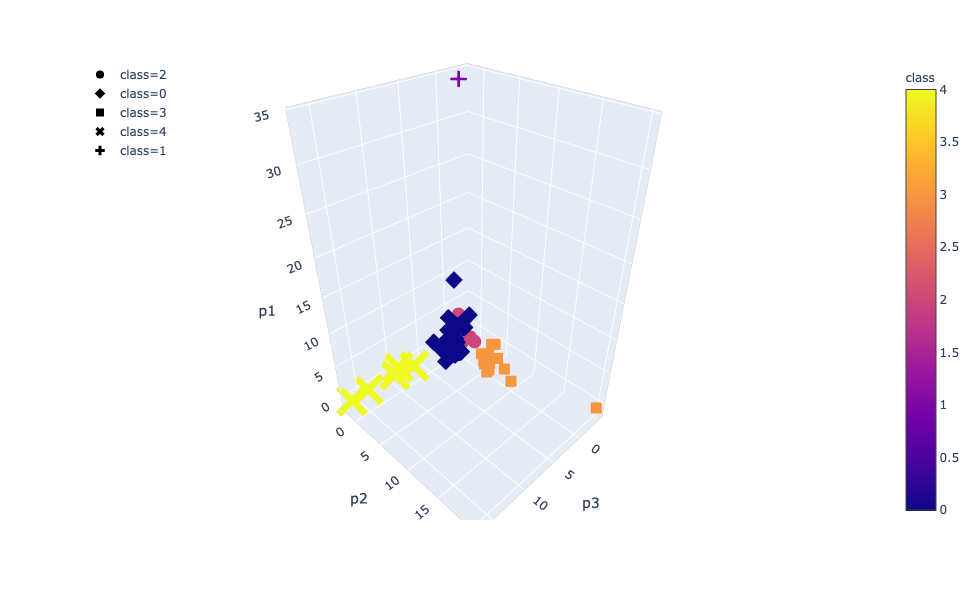

In [94]:
# Creating a 3D-Scatter with the PCA data and the clusters
import plotly.express as px
fig = px.scatter_3d(
    result,
    x="p3",
    y="p2",
    z="p1",
    color="class",
    symbol="class",
    hover_name="CoinName",
    hover_data=["Algorithm"],
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

#### Table of Tradable Cryptocurrencies

In [95]:
# Table with tradable cryptos
result.hvplot.table()

:Table   [index,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,p1,p2,p3,class,CoinName]

#### Scatter Plot with Tradable Cryptocurrencies

In [ ]:
# Scaling data to create the scatter plot

In [96]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
result.hvplot.scatter(x='TotalCoinsMined', y='TotalCoinSupply',hover_cols=["CoinName"])

:Scatter   [TotalCoinsMined]   (TotalCoinSupply,CoinName)